In [62]:
# Import packages
import math
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Financial data forecast

In [63]:
### Import data
start = datetime.strptime('2016-01-01','%Y-%m-%d')
end = datetime.strptime('2022-3-31','%Y-%m-%d')
series_name, code = r'EUR/USD', 'DEXUSEU'

df = data.DataReader(code, start=start, end=end, data_source='fred')[code]
df = df[~np.isnan(df)]

Text(0, 0.5, 'EUR/USD Price')

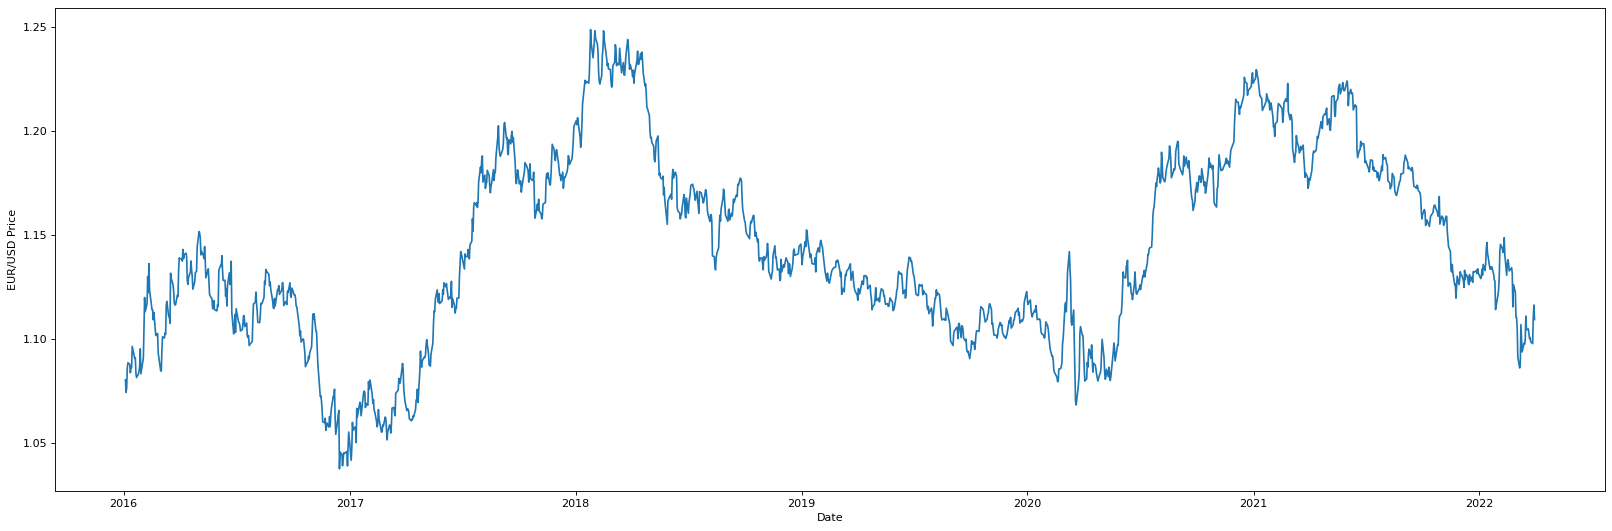

In [64]:
### Plot the series
fig = plt.figure(figsize=(25,8), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(df)
ax.set_xlabel('Date')
ax.set_ylabel('{} Price'.format(series_name))

### I. ARIMA

In [65]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller test for stationarity:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print("\n")
    
## Test whether log(df) is stationary
df_log = np.log(df)
test_stationarity(df_log.dropna()) 

## Test whether diff(log(df)) is stationary => d=1, if reject H0: Not stationary
df_log_diff1 = df_log - df_log.shift()
test_stationarity(df_log_diff1.dropna()) 

Results of Dickey-Fuller Test:
Test Statistic                   -2.484624
p-value                           0.119260
#Lags Used                        1.000000
Number of Observations Used    1557.000000
Critical Value (1%)              -3.434557
Critical Value (5%)              -2.863398
Critical Value (10%)             -2.567759
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.495119e+01
p-value                        1.279637e-27
#Lags Used                     8.000000e+00
Number of Observations Used    1.549000e+03
Critical Value (1%)           -3.434579e+00
Critical Value (5%)           -2.863408e+00
Critical Value (10%)          -2.567764e+00
dtype: float64




Text(0.5, 1.0, 'Partial Autocorrelation Function')

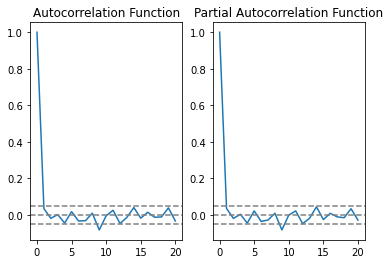

In [66]:
# Build ARIMA model
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_log_diff1.dropna(), nlags=20)
lag_pacf = pacf(df_log_diff1.dropna(), nlags=20, method='ols')

# Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff1)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff1)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
# plt.tight_layout()

In [67]:
### Split out training and test datasets
training_size = int(len(df)*0.8)
test_size = len(df)-training_size
train_data, test_data = np.log(df)[0:training_size], np.log(df)[training_size:len(df)]

In [68]:
# Build ARIMA model
model_arima = ARIMA(train_data, order=(2, 1, 0))
model_arima_fit = model_arima.fit()

model_arima_fit.summary()

C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                DEXUSEU   No. Observations:                 1247
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4971.291
Date:                Tue, 19 Apr 2022   AIC                          -9936.582
Time:                        22:48:39   BIC                          -9921.199
Sample:                             0   HQIC                         -9930.798
                               - 1247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0425      0.024      1.770      0.077      -0.005       0.090
ar.L2         -0.0004      0.027     -0.015      0.988      -0.052       0.052
sigma2      2.004e-05   5.43e-07     36.928      0.000     1.9e-05    2.11e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               311.92
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\envs\lihua\lib\site-packages\statsmo

<AxesSubplot:title={'center':'ARIMA(2,1,0) prediction of EUR/USD'}, xlabel='DATE'>

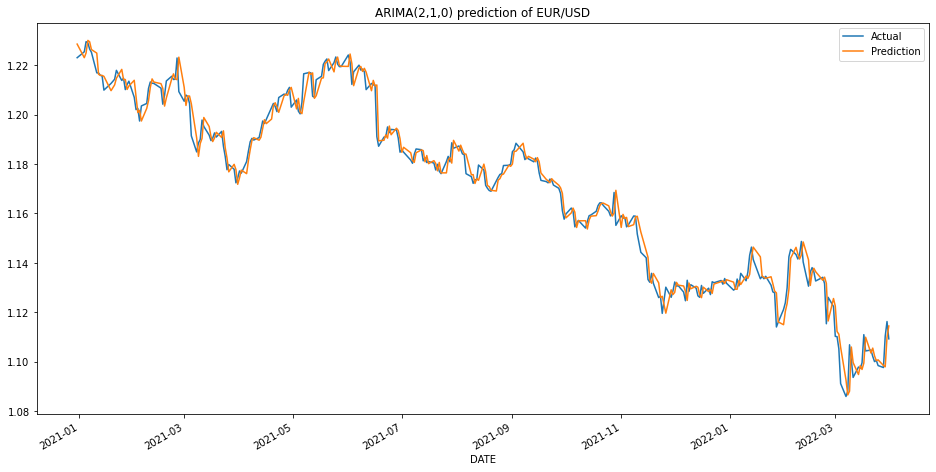

In [69]:
# Evaluate ARIMA model
def evaluate_arima_model(train, test, time_step, arima_order):
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history[-time_step:], order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  
  # Calculate out of sample error
  error_mae = mean_absolute_error(test, predictions)
  error_mape = mean_absolute_percentage_error(test, predictions)
  error_rmse = math.sqrt(mean_squared_error(test, predictions))
  return({'mae': error_mae, 'mape': error_mape, 'rmse': error_rmse}, predictions)

arima_error, predictions = evaluate_arima_model(train_data, test_data, 100, (2,1,0))

pd.DataFrame({'Actual': np.exp(test_data),
              'Prediction': np.exp(np.array(predictions).reshape((-1,)))}).plot(figsize=(16,8), title='ARIMA(2,1,0) prediction of {}'.format(series_name))

In [70]:
arima_error

{'mae': 0.00294147041923569,
 'mape': 0.020537712525592555,
 'rmse': 0.0040719816132461315}

### II. LSTM model

In [71]:
### Map all data into [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df_LSTM = scaler.fit_transform(np.array(df).reshape(-1,1))

In [72]:
training_size = int(len(df_LSTM)*0.8)
test_size = len(df_LSTM)-training_size
train_data, test_data = df_LSTM[0:training_size,:], df_LSTM[training_size:len(df_LSTM),:]

In [73]:
### Build input features with time lag of 1 day
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [74]:
### Reshape the datasets into (#values, #time-steps, #1 dimensional output)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

In [86]:
### Build different LSTM models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

loss_func = 'mean_squared_error'
opt = 'adam'
metric = ['mse']

model = Sequential() 
model.add(LSTM(50, return_sequences = True, input_shape = (100,1))) 
model.add(LSTM(50, return_sequences = True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss = loss_func, optimizer = opt, metrics = metric)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [87]:
### Train LSTM models
epoch = 100
batch_size = 64

lstm_history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = epoch, batch_size = batch_size, verbose = 1)

Epoch 1/100
18/18 [==============================] - 7s 181ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/100
18/18 [==============================] - 4s 206ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 3/100
18/18 [==============================] - 4s 245ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/100
18/18 [==============================] - 4s 236ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/100
18/18 [==============================] - 4s 220ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 6/100
18/18 [==============================] - 4s 208ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/100
18/18 [==============================] - 4s 215ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/100
18/18 [==============================] - 4s 218ms/step - 

In [99]:
### Make predictions and inverse-map (0,1) to the true stock prices
def predictLSTM(model, train_input, test_input):
    train_predict = model.predict(train_input)
    test_predict = model.predict(test_input)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    return train_predict, test_predict

train_predict, test_predict = predictLSTM(model, x_train, x_test)

In [100]:
### Evaluate the LSTM model
print("Loss/Metrics of training dataset", model.evaluate(x_train, y_train, verbose=0),
      "\nLoss/Metrics of test dataset", model.evaluate(x_test, y_test, verbose=0))

Loss/Metrics of training dataset [0.0005871903267689049, 0.0005871903267689049] 
Loss/Metrics of test dataset [0.0005623339675366879, 0.0005623339675366879]


In [101]:
### Get predictions for the whole dataset
look_back = 100

def predict_plot(look_back, train_predict, test_predict):
    trainPredictPlot = np.empty_like(df_LSTM)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(df_LSTM)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_LSTM)-1,:] = test_predict
    return trainPredictPlot, testPredictPlot

trainPredictPlot, testPredictPlot = predict_plot(look_back, train_predict, test_predict)

<function matplotlib.pyplot.show(close=None, block=None)>

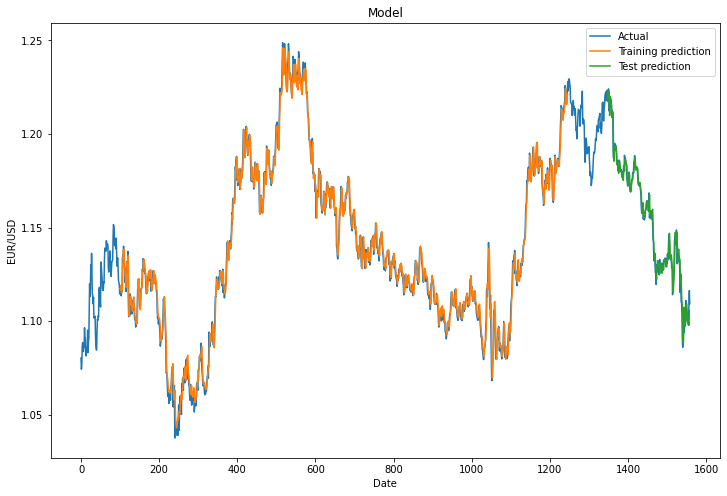

In [102]:
### Plot predictions for the whole dataset
plt.figure(figsize = (12,8))
plt.plot(scaler.inverse_transform(df_LSTM), label='Actual')
plt.plot(trainPredictPlot, label='Training prediction')
plt.plot(testPredictPlot, label='Test prediction')
plt.title("Model")
plt.xlabel('Date')
plt.ylabel('EUR/USD')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

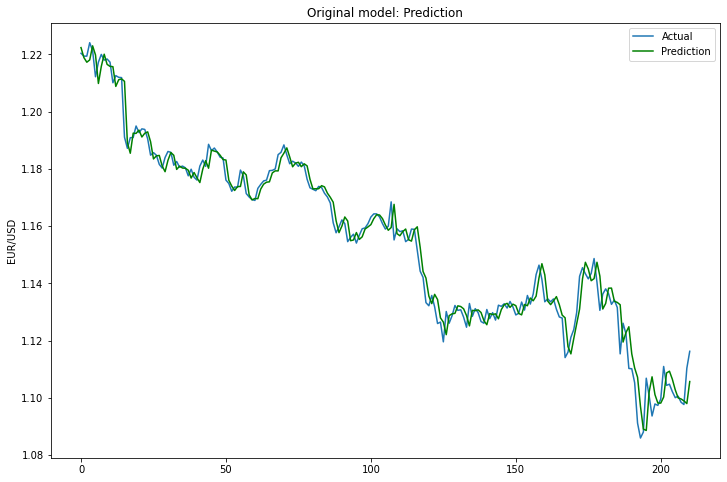

In [103]:
### Plot predictions for test datasets (i.e., zoom in)
plt.figure(figsize = (12,8))
plt.plot(scaler.inverse_transform(df_LSTM)[len(train_predict)+(look_back*2)+1:len(df_LSTM)-1], label='Actual')
plt.plot(test_predict, color='g', label='Prediction')
plt.title("Original model: Prediction")
plt.ylabel('EUR/USD')
plt.legend()
plt.show

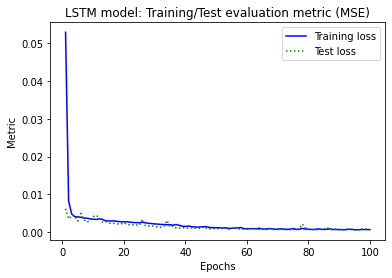

In [104]:
### Plot history for loss
loss_train = lstm_history.history['loss']
loss_test = lstm_history.history['val_loss']

epochs = range(1, epoch+1)

def chart_eval(train_metric_value, test_metric_value, model_title, metric_func):
    plt.plot(epochs, train_metric_value, color='b', label='Training loss')
    plt.plot(epochs, test_metric_value, color='g', linestyle=':', label='Test loss')
    plt.title(model_title + ': Training/Test evaluation metric' + ' (' + metric_func + ')')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

chart_eval(loss_train, loss_test, "LSTM model", "MSE")